In [1]:
# Librerias utilizadas.
## Importación de datos.
from sqlalchemy import create_engine
## Tratamiento de datos.
import pandas as pd
import numpy as np
## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
## Preprocesado y modelado.
from sklearn import datasets, linear_model, metrics, svm, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = '172.30.248.86'
mysql_port = '3306'
mysql_username = 'mms'
mysql_password = 'agedb'
mysql_dbname = 'aoe2de'
# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
/*MBL*/
SELECT
    matches.version,
    matches.server,
    matches.duration_minutes AS 'duration',
    players.rating,
    players.color,
    players.civ,
    players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.map_type = 'Arabia'
AND
    matches.rating_type = '1v1 Random Map'
AND
    players.profile_id = '251265';
"""
df = pd.read_sql_query(query, con=cnx)
df.shape

(1170, 7)

In [4]:
df.head(10)

,version,server,duration,rating,color,civ,won
0,36202,unknown,20,2142.0,red,Mayans,1
1,36202,eastus,10,2219.0,yellow,Franks,1
2,36906,ukwest,31,2244.0,yellow,Aztecs,1
3,36906,ukwest,28,2199.0,red,Khmer,1
4,36906,ukwest,8,2191.0,yellow,Chinese,1
5,36906,ukwest,34,2191.0,yellow,Britons,0
6,36906,brazilsouth,40,2206.0,green,Britons,1
7,36906,brazilsouth,17,2191.0,red,Chinese,0
8,36906,brazilsouth,1,2199.0,red,Aztecs,1
9,36906,brazilsouth,27,2211.0,blue,Aztecs,0


In [5]:
df.tail(10)

,version,server,duration,rating,color,civ,won
1160,47820,ukwest,10,2523.0,red,Malians,1
1161,47820,ukwest,52,2526.0,red,Mayans,0
1162,47820,ukwest,31,2512.0,red,Koreans,1
1163,47820,ukwest,19,2515.0,red,Goths,0
1164,47820,ukwest,52,2510.0,red,Koreans,0
1165,47820,ukwest,26,2505.0,red,Lithuanians,1
1166,47820,ukwest,11,2515.0,blue,Ethiopians,1
1167,47820,ukwest,19,2518.0,blue,Magyars,0
1168,47820,ukwest,27,2506.0,red,Indians,1
1169,47820,ukwest,20,2525.0,blue,Portuguese,1


In [6]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

version     0
server      0
duration    0
rating      2
color       0
civ         0
won         0
dtype: int64

In [7]:
# Eliminar registros donde la variable "rating" es NaN.
df.dropna(inplace=True)
df.shape

(1168, 7)

In [8]:
# Poner la primera letra en mayúsculas.
df['color']   = df['color'].str.capitalize()
df['server'] = df['server'].str.capitalize()
# Convertir variable "rating" de float64 a int64.
df['rating'] = df['rating'].astype('int64')
df.head(10)

,version,server,duration,rating,color,civ,won
0,36202,Unknown,20,2142,Red,Mayans,1
1,36202,Eastus,10,2219,Yellow,Franks,1
2,36906,Ukwest,31,2244,Yellow,Aztecs,1
3,36906,Ukwest,28,2199,Red,Khmer,1
4,36906,Ukwest,8,2191,Yellow,Chinese,1
5,36906,Ukwest,34,2191,Yellow,Britons,0
6,36906,Brazilsouth,40,2206,Green,Britons,1
7,36906,Brazilsouth,17,2191,Red,Chinese,0
8,36906,Brazilsouth,1,2199,Red,Aztecs,1
9,36906,Brazilsouth,27,2211,Blue,Aztecs,0


In [9]:
# Convertir variables object a category.
df['version']   = df['version'].astype('category')
df['server']    = df['server'].astype('category')
df['color']      = df['color'].astype('category')
df['civ']           = df['civ'].astype('category')

In [10]:
# Comprobación de cada tipo de variable.
df.dtypes

version     category
server      category
duration       int64
rating         int64
color       category
civ         category
won            int64
dtype: object

In [11]:
# Estadísticos básicos de las variables numéricas.
df.describe()

,duration,rating,won
count,1168.000000,1168.000000,1168.000000
mean,23.447774,2409.233733,0.716610
std,9.793008,75.368874,0.450837
min,0.000000,2142.000000,0.000000
25%,17.000000,2358.000000,0.000000
50%,23.000000,2423.000000,1.000000
75%,29.000000,2462.000000,1.000000
max,70.000000,2552.000000,1.000000


<AxesSubplot:xlabel='rating', ylabel='Density'>

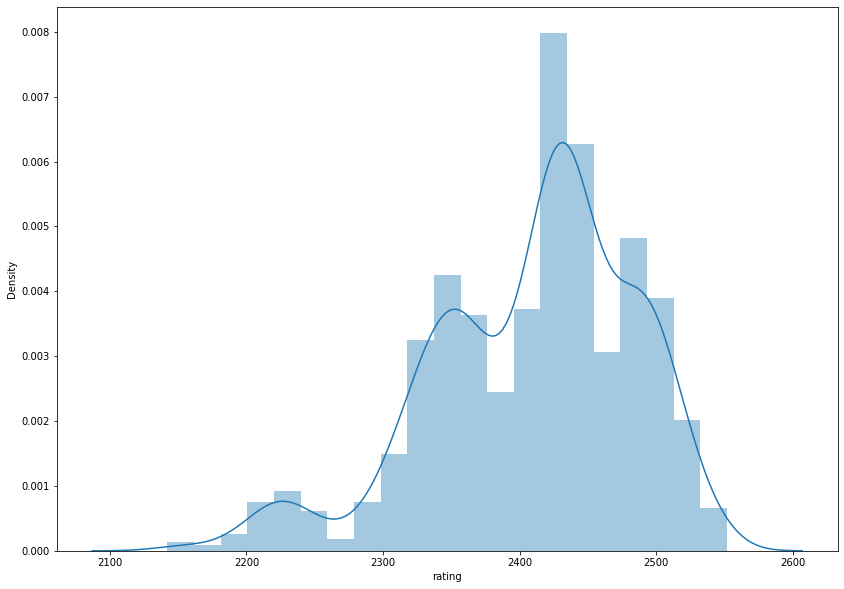

In [12]:
sns.distplot(df.rating)

<AxesSubplot:xlabel='rating'>

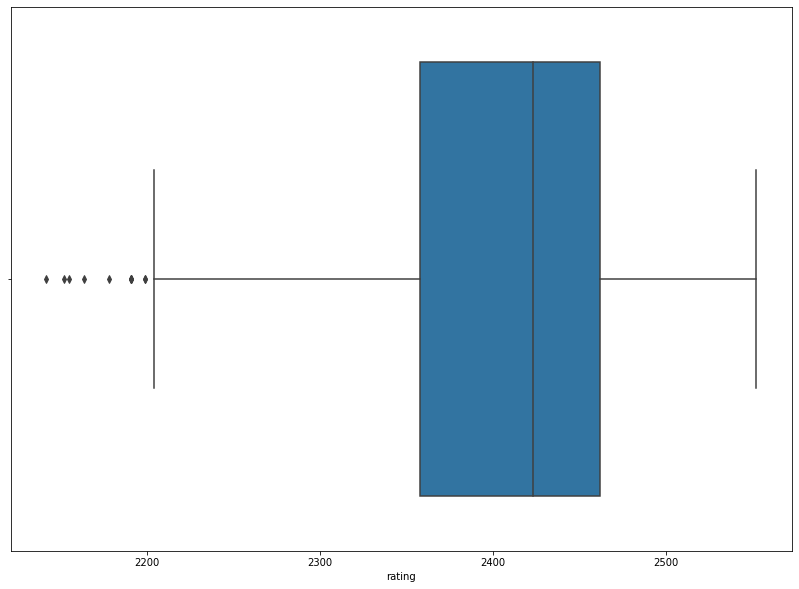

In [13]:
sns.boxplot(df.rating)

<AxesSubplot:xlabel='duration', ylabel='Density'>

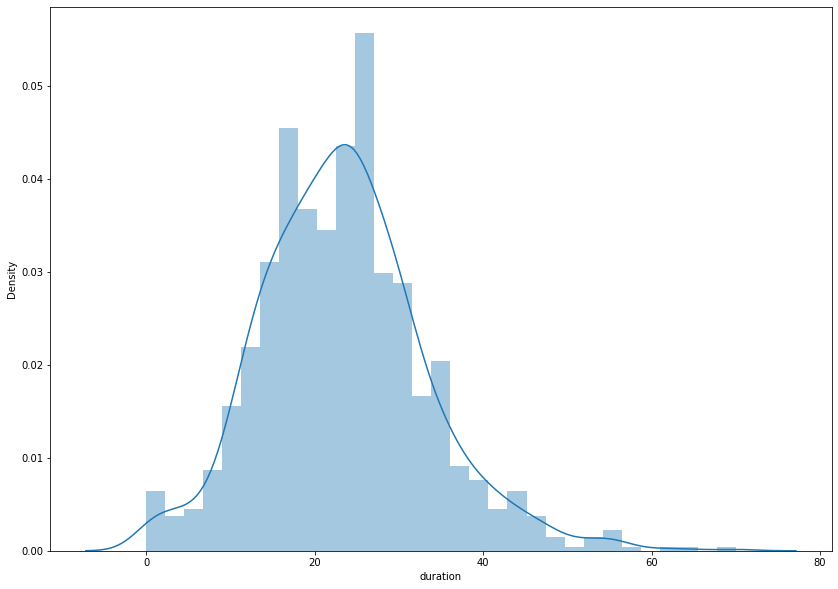

In [14]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='duration'>

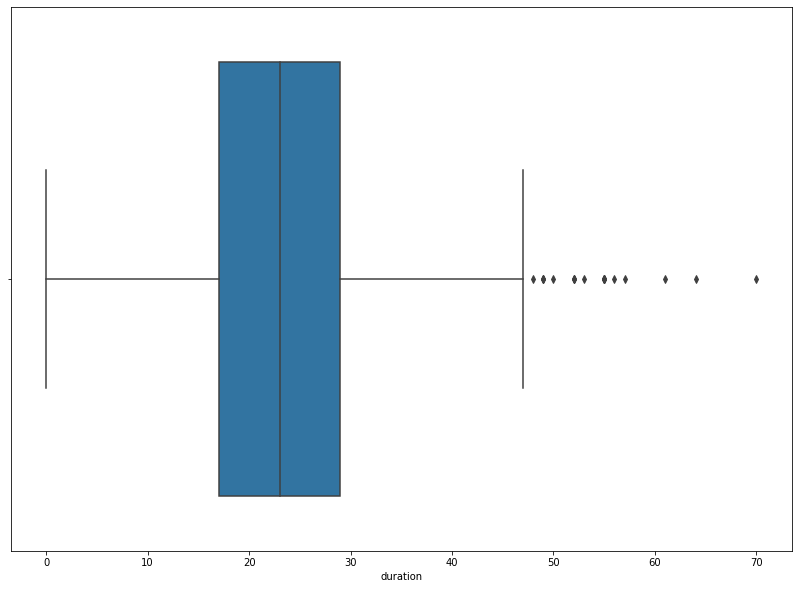

In [15]:
sns.boxplot(df.duration)

In [16]:
# Valores únicos de la variable "version".
versions = df.version.unique().tolist()
versions.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por versión".
def get_frequency_rates_by_version(df):
    return pd.DataFrame(df.version.value_counts(normalize=True)).reset_index().rename(columns={"index": "version", "version": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por versión".
def get_win_rates_by_version(df):
    return (
        df.groupby("version")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_version = get_frequency_rates_by_version(df)
win_rates_version              = get_win_rates_by_version(df)

Text(0.5, 1.0, 'Frecuencia de partidas por version')

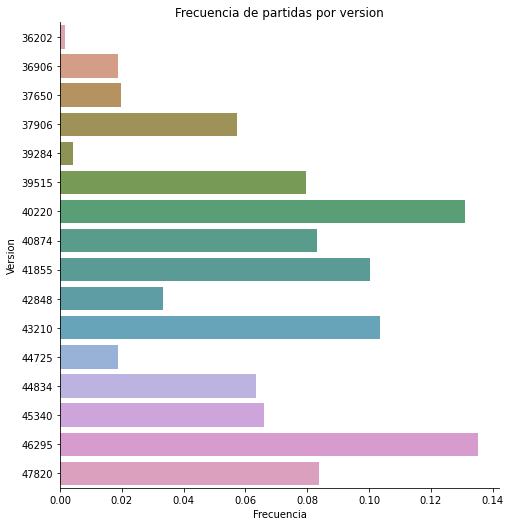

In [17]:
sns.catplot(y="version", x="frequency",  data=frequency_rates_version, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Version")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por version")

Text(0.5, 1.0, 'Tasa de victorias por versión')

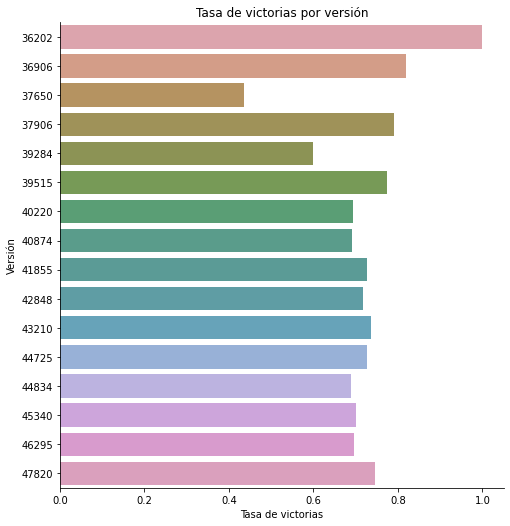

In [18]:
sns.catplot(y="version", x="win_rate",  data=win_rates_version, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Versión")
plt.xlabel("Tasa de victorias")
plt.title("Tasa de victorias por versión")

In [19]:
# Valores únicos de la variable "server".
servers = df.server.unique().tolist()
servers.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por servidor".
def get_frequency_rates_by_server(df):
    return pd.DataFrame(df.server.value_counts(normalize=True)).reset_index().rename(columns={"index": "server", "server": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por servidor".
def get_win_rates_by_server(df):
    return (
        df.groupby("server")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_server = get_frequency_rates_by_server(df)
win_rates_server              = get_win_rates_by_server(df)

Text(0.5, 1.0, 'Frecuencia de partidas por servidor')

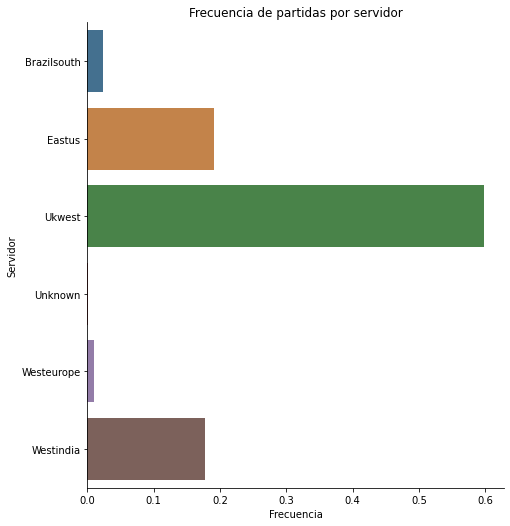

In [20]:
sns.catplot(y="server", x="frequency",  data=frequency_rates_server, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Servidor")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por servidor")

Text(0.5, 1.0, 'Tasa de victorias por servidor')

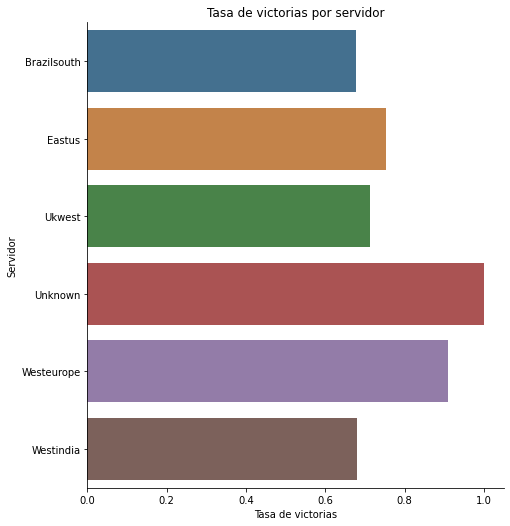

In [21]:
sns.catplot(y="server", x="win_rate",  data=win_rates_server, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Servidor")
plt.xlabel("Tasa de victorias")
plt.title("Tasa de victorias por servidor")

In [22]:
# Valores únicos de la variable "color".
colors = df.color.unique().tolist()
colors.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_color(df):
    return pd.DataFrame(df.color.value_counts(normalize=True)).reset_index().rename(columns={"index": "color", "color": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_color(df):
    return (
        df.groupby("color")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_color = get_frequency_rates_by_color(df)
win_rates_color              = get_win_rates_by_color(df)

Text(0.5, 1.0, 'Frecuencia de partidas por color')

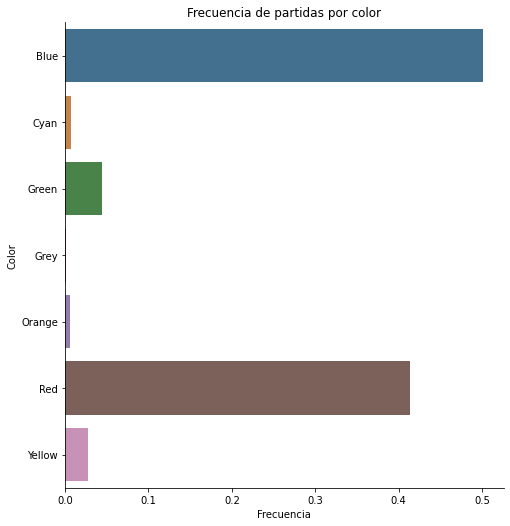

In [23]:
sns.catplot(y="color", x="frequency",  data=frequency_rates_color, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Color")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por color")

Text(0.5, 1.0, 'Tasa de victorias por color')

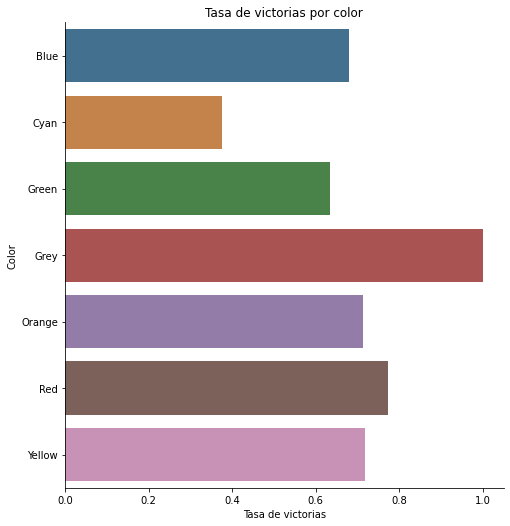

In [24]:
sns.catplot(y="color", x="win_rate",  data=win_rates_color, saturation=0.5, kind="bar", ci=None, aspect=1, height=7, orient="h")
plt.ylabel("Color")
plt.xlabel("Tasa de victorias")
plt.title("Tasa de victorias por color")

In [25]:
# Valores únicos de la variable "civ".
civs = df.civ.unique().tolist()
civs.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_civ = get_frequency_rates_by_civ(df)
win_rates_civ              = get_win_rates_by_civ(df)

Text(0.5, 1.0, 'Frecuencia de partidas por civilización')

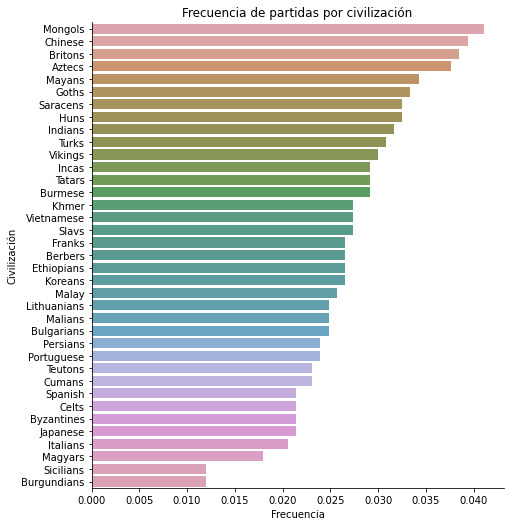

In [26]:
sns.catplot(y="civ",
                        x="frequency", 
                        data=frequency_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h",
                        order=frequency_rates_civ.sort_values('frequency', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por civilización")

Text(0.5, 1.0, 'Tasa de victorias por civilización')

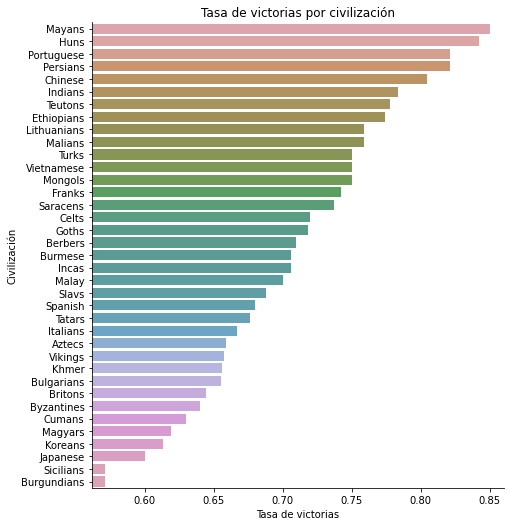

In [27]:
sns.catplot(y="civ",
                        x="win_rate", 
                        data=win_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h", 
                        order=win_rates_civ.sort_values('win_rate', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Tasa de victorias")
lim_sup = float(win_rates_civ.win_rate.head(1) + 0.01)
lim_inf = float(win_rates_civ.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Tasa de victorias por civilización")

In [28]:
# Función para la creación de variables dummy.
def create_dummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df
# Creación variables dummy.
categorical = ["version", "server", "color", "civ"]
for category in categorical:
    df = create_dummies(df, category)

In [29]:
# Transformación de las entidades escalando cada entidad a un rango determinado.
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled

,duration,rating,won,version_36202,version_36906,version_37650,version_37906,version_39284,version_39515,version_40220,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
0,0.285714,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,0.187805,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.442857,0.248780,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.400000,0.139024,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.114286,0.119512,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,0.371429,0.885366,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1166,0.157143,0.909756,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,0.271429,0.917073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1168,0.385714,0.887805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Selección de rasgos para el modelo.
features = len(df_scaled.columns.values)
summary_models_logreg = pd.DataFrame(columns=['initial_features', 
                                                                                                       'final_features',
                                                                                                       'aic',
                                                                                                       'bic',
                                                                                                       'df_residuals',
                                                                                                       'r_squared',
                                                                                                       'score_accuracy',
                                                                                                       'roc_auc_score'])
for f in range(4, features, 4):
    print("-------------")
    print("Features:", f)
    # Recursive Feature Elimination
    df_vars=df_scaled.columns.values.tolist()
    y_var=['won']
    X_var=[i for i in df_vars if i not in y_var]
    y = pd.DataFrame(data=df_scaled,columns=y_var)
    X = pd.DataFrame(data=df_scaled,columns=X_var)
    logreg_sklearn = LogisticRegression()
    rfe = RFE(logreg_sklearn, f)
    try:
        rfe = rfe.fit(X, y.values.ravel())
        cols = []
        for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
            if selected == True:
                cols.append(var)
        X=df_scaled[cols]
        y=df_scaled['won']

        # Implementing the model
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Remove unsignificant variables
        pvalues = list(logreg_sm_results.pvalues)
        cols_s = pd.DataFrame(list(zip(cols, pvalues)))
        cols_s.columns = ["variable", "pvalue"]
        cols_s = cols_s[cols_s["pvalue"] <= 0.05]
        cols_s.reset_index(inplace=True, drop=True)
        cols_s = list(cols_s["variable"])
        X=df_scaled[cols_s]
        y=df_scaled['won']
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Logistic Regression Model Fitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logreg_sklearn = LogisticRegression()
        logreg_sklearn.fit(X_train, y_train)
        from sklearn.metrics import roc_auc_score
        logreg_sklearn_roc_auc = roc_auc_score(y_test, logreg_sklearn.predict(X_test))

        # Final features.
        final_features = len(logreg_sm_results.params)
        # Akaike’s information criteria.
        aic = round(logreg_sm_results.aic, 4)
        # Bayes’ information criteria.
        bic = round(logreg_sm_results.bic, 4)
        # Residual degrees of freedom.
        df_resid = int(logreg_sm_results.df_resid)
        # R squared.
        rsquared = round(logreg_sm_results.prsquared, 4)
        # Score of logreg_sklearn.
        score_accuracy = round(logreg_sklearn.score(X_test, y_test), 4)
        # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
        roc_auc_score = round(logreg_sklearn_roc_auc, 4)

        # Append to final dataframe summary of logistic regression.
        data_to_append = [f, final_features, aic, bic, df_resid, rsquared, score_accuracy, roc_auc_score]
        a_series = pd.Series(data_to_append, index=summary_models_logreg.columns)
        summary_models_logreg = summary_models_logreg.append(a_series, ignore_index=True)
    except:
        pass

-------------
Features: 4
Optimization terminated successfully.
         Current function value: 0.631976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633406
         Iterations 6
-------------
Features: 8
Optimization terminated successfully.
         Current function value: 0.623131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629478
         Iterations 6
-------------
Features: 12
Optimization terminated successfully.
         Current function value: 0.620932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629478
         Iterations 6
-------------
Features: 16
Optimization terminated successfully.
         Current function value: 0.596222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604279
         Iterations 6
-------------
Features: 20
Optimization terminated successfully.
         Curr

In [31]:
summary_models_logreg = summary_models_logreg.sort_values(by=['score_accuracy', 'roc_auc_score', 'r_squared'], ascending=[False, False, False]).reset_index(drop=True)
summary_models_logreg.head(10)

,initial_features,final_features,aic,bic,df_residuals,r_squared,score_accuracy,roc_auc_score
0,68.0,1.0,1496.3108,1501.3738,1167.0,-0.0731,0.7151,0.5168
1,16.0,6.0,1423.5954,1453.9737,1162.0,-0.0137,0.7123,0.5177
2,64.0,2.0,1440.9361,1451.0622,1166.0,-0.0319,0.7123,0.5148
3,8.0,4.0,1478.4600,1498.7122,1164.0,-0.0559,0.7123,0.5148
4,12.0,4.0,1478.4600,1498.7122,1164.0,-0.0559,0.7123,0.5148
5,4.0,3.0,1485.6373,1500.8264,1165.0,-0.0625,0.7123,0.5148
6,60.0,3.0,1427.3273,1442.5164,1165.0,-0.0207,0.7094,0.5098
7,52.0,6.0,1351.9324,1382.3107,1162.0,0.0378,0.7066,0.5108
8,56.0,6.0,1351.9324,1382.3107,1162.0,0.0378,0.7066,0.5108
9,20.0,7.0,1339.7721,1375.2135,1161.0,0.0480,0.7066,0.5049


In [32]:
f = int(summary_models_logreg.initial_features[1])
# Recursive Feature Elimination
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
logreg_sklearn = LogisticRegression()
rfe = RFE(logreg_sklearn, f)
rfe = rfe.fit(X, y.values.ravel())
cols = []
for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
    if selected == True:
        cols.append(var)
X=df_scaled[cols]
y=df_scaled['won']

# Implementing the model
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

# Remove unsignificant variables
pvalues = list(logreg_sm_results.pvalues)
cols_s = pd.DataFrame(list(zip(cols, pvalues)))
cols_s.columns = ["variable", "pvalue"]
cols_s = cols_s[cols_s["pvalue"] <= 0.05]
cols_s.reset_index(inplace=True, drop=True)
cols_s = list(cols_s["variable"])
X=df_scaled[cols_s]
y=df_scaled['won']
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.596222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604279
         Iterations 6


In [33]:
logreg_sm_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: -0.014   
Dependent Variable: won              AIC:              1423.5954
Date:               2021-07-02 17:37 BIC:              1453.9737
No. Observations:   1168             Log-Likelihood:   -705.80  
Df Model:           5                LL-Null:          -696.28  
Df Residuals:       1162             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
duration          0.9015   0.2115  4.2615 0.0000  0.4869  1.3161
version_37650    -0.9426   0.4397 -2.1438 0.0320 -1.8043 -0.0808
version_39515     0.5461   0.2604  2.0971 0.0360  0.0357  1.0566
color_Red         0.8806   0.1259  6.9955 0.0000  0.6339  1.1273
civ_Huns          1.1008   0.4526  2.4321 0.0150  0.2137  1.9878
civ_Mayans        1.1715   0.4531  2.5856 0.0097  0.2835  2.0595
================================================================

"""

In [34]:
coefficients = dict(logreg_sm_results.params)
coefficients = pd.DataFrame.from_dict(coefficients, orient='index').reset_index(level=0)
coefficients.columns = ['Variable', 'Coeficiente']
coefficients

,Variable,Coeficiente
0,duration,0.901509
1,version_37650,-0.942560
2,version_39515,0.546150
3,color_Red,0.880606
4,civ_Huns,1.100755
5,civ_Mayans,1.171518


In [35]:
for index, row in coefficients.iterrows():
    print("Si la variable " + row["Variable"] + " incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en " + str(round(row["Coeficiente"], 3)))

Si la variable duration incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 0.902
Si la variable version_37650 incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en -0.943
Si la variable version_39515 incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 0.546
Si la variable color_Red incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 0.881
Si la variable civ_Huns incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.101
Si la variable civ_Mayans incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.172


In [36]:
corr = X.corr().abs()
corr = corr[corr > 0.7]
corr

,duration,version_37650,version_39515,color_Red,civ_Huns,civ_Mayans
duration,1.0,NaN,NaN,NaN,NaN,NaN
version_37650,NaN,1.0,NaN,NaN,NaN,NaN
version_39515,NaN,NaN,1.0,NaN,NaN,NaN
color_Red,NaN,NaN,NaN,1.0,NaN,NaN
civ_Huns,NaN,NaN,NaN,NaN,1.0,NaN
civ_Mayans,NaN,NaN,NaN,NaN,NaN,1.0


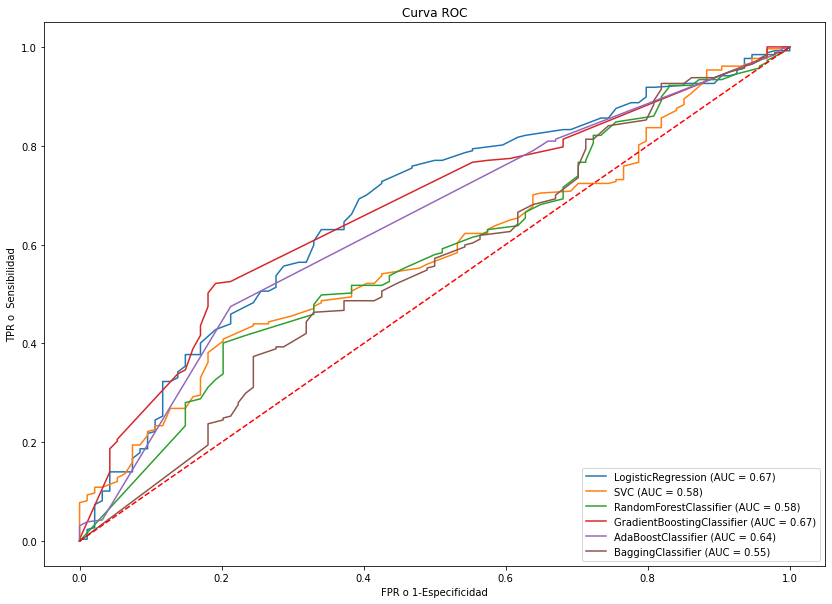

In [37]:
from sklearn.metrics import plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
ax=plt.gca()
# LogisticRegression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(X_train, y_train)
logreg_sklearn_roc = plot_roc_curve(logreg_sklearn, X_test, y_test, ax=ax)
# SVC (Support Vector Classification)
svc_sklearn = SVC(random_state=2021)
svc_sklearn.fit(X_train, y_train)
svc_sklearn_roc = plot_roc_curve(svc_sklearn, X_test, y_test, ax=ax)
# RandomForestClassifier
rfc_sklearn = RandomForestClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
rfc_sklearn.fit(X_train, y_train)
rfc_sklearn_roc = plot_roc_curve(rfc_sklearn, X_test, y_test, ax=ax)
# GradientBoostingClassifier
gbc_sklearn = GradientBoostingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
gbc_sklearn.fit(X_train, y_train)
gbc_sklearn_roc = plot_roc_curve(gbc_sklearn, X_test, y_test, ax=ax)
# AdaBoostClassifier
abc_sklearn = AdaBoostClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
abc_sklearn.fit(X_train, y_train)
abc_sklearn_roc = plot_roc_curve(abc_sklearn, X_test, y_test, ax=ax)
# BaggingClassifier
bgc_sklearn =BaggingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
bgc_sklearn.fit(X_train, y_train)
bgc_sklearn_roc = plot_roc_curve(bgc_sklearn, X_test, y_test, ax=ax)

plt.title("Curva ROC")
plt.ylabel("TPR o  Sensibilidad")
plt.xlabel("FPR o 1-Especificidad")
plt.plot([0, 1], [0, 1],'r--')
rcParams['figure.figsize'] = 16, 10
# plt.rcParams["figure.figsize"] = (12, 12)
plt.show()

In [38]:
# Scores.
score_lr     = round(logreg_sklearn.score(X_test, y_test), 5)
score_svc = round(svc_sklearn.score(X_test, y_test), 5)
score_rfc  = round(rfc_sklearn.score(X_test, y_test), 5)
score_gbc = round(gbc_sklearn.score(X_test, y_test), 5)
score_abc = round(abc_sklearn.score(X_test, y_test), 5)
score_bgc = round(bgc_sklearn.score(X_test, y_test), 5)
# Asignar datos de la lista.  
results = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score': [score_lr, score_svc, score_rfc, score_gbc, score_abc, score_bgc]}  
# Crear DataFrame .
df_results = pd.DataFrame(results)  
# Imprimir listado de Scores.  
df_results.sort_values(by=['Score'], ascending=False, ignore_index=True)

,Model,Score
0,GradientBoostingClassifier,0.73504
1,SVC (SupportVectorClassifier),0.73219
2,LogisticRegression,0.72934
3,AdaBoostClassifier,0.72650
4,RandomForestClassifier,0.67521
5,BaggingClassifier,0.67236


In [39]:
# Scores CV.
score_lr_cv     = round(cross_val_score(logreg_sklearn, X, y, cv=10).mean(), 5)
score_svc_cv = round(cross_val_score(svc_sklearn, X, y, cv=10).mean(), 5)
score_rfc_cv  = round(cross_val_score(rfc_sklearn, X, y, cv=10).mean(), 5)
score_gbc_cv = round(cross_val_score(gbc_sklearn, X, y, cv=10).mean(), 5)
score_abc_cv = round(cross_val_score(abc_sklearn, X, y, cv=10).mean(), 5)
score_bgc_cv = round(cross_val_score(bgc_sklearn, X, y, cv=10).mean(), 5)
# Asignar datos de la lista.   
results_cv = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score CV 10': [score_lr_cv, score_svc_cv, score_rfc_cv, score_gbc_cv, score_abc_cv, score_bgc_cv]}  
# Crear DataFrame .
df_results_cv = pd.DataFrame(results_cv)  
# Imprimir listado de Scores CV.  
df_results_cv.sort_values(by=['Score CV 10'], ascending=False, ignore_index=True)

,Model,Score CV 10
0,SVC (SupportVectorClassifier),0.71661
1,GradientBoostingClassifier,0.71661
2,LogisticRegression,0.71575
3,AdaBoostClassifier,0.71148
4,RandomForestClassifier,0.68235
5,BaggingClassifier,0.68065
